# Estimating the Loss of Medieval Literature with an Unseen Species model from Ecodiversity

In [1]:
import numpy as np
np.random.seed(764513)
import scipy.stats as stats
from scipy.special import gammaln
import scipy.optimize as optim
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
from functools import partial
import seaborn as sb
from tqdm.notebook import tqdm

This notebook accompanies a short paper for the first [Computational Humanities Research Workshop](https://www.computational-humanities-research.org/) (18-20 november 2020; to be held online). It is part of a repository that contains all the code and software (with some documentation interwoven) necessary to replicate our findings; it will be archived on [Zenodo](https://zenodo.org/). The paper offers a more technical complement to and extension of a Dutch-language journal article that was previously published, but which was targeted at a broader audience of literary historians:

> Kestemont, M. & Karsdorp, F., ‘Het Atlantis van de Middelnederlandse ridderepiek. Een schatting van het tekstverlies met methodes uit de ecodiversiteit’, *Spiegel der Letteren* 61:3 (2019), 271-290.

We ran all the code below in an [Anaconda](https://www.anaconda.com/) installation of Python 3.6.10. The top-level directory of this repository has a `requirements.txt` file that you can use to install the more specific version of the third-party packages used here. Note that the data used here feature a number of minor improvements in comparison to that for the SDL paper (with some insignificant fluctuations in the results).

## The loss of works

### Data

We start by loading the data for the case study, which is the tradition of Middle Dutch chivalric epics (*Middelnederlandse ridderepiek*, ca. 1150-1450 AD). This data comes in the form a single spreadsheet and has mainly been drawn Kienhorst's acclaimed 1988 repertory, with the addition of new manuscript finds since then:

> H. Kienhorst, *De handschriften van de Middelnederlandse ridderepiek. Een codicologischebeschrijving. Deel 1*. Deventer studieën 9, Sub Rosa, 1988.

In [2]:
df = pd.read_excel('../data/mnl_chiv.xlsx', header=None)
df.columns = ('work', 'sigle', 'signature', 'fragmentary')
df.head()

,work,sigle,signature,fragmentary
0,Aiol (1),H1,"Leiden, UB, BPL 1049; Brussel, KB, IV 816",True
1,Aiol (2),H2,"Breda, Arch. Begijnhof, z.s.",True
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek, Cod. ge...",False
3,Alexanders geesten,H3,"Gent, UB, 2749,6",True
4,Alexanders geesten,H4,"Leiden, UB, Ltk. 1196",True


As you can see, each row represents a single textual witness or observation of a Middle Dutch chivalric epic:

- *work*: the title of the (abstract notion of a) "work" which is attested in the witness (i.e. the species in the ecological analogy);
- *sigle*: Kienhorst's code for the manuscript, if applicable (not really used here, but potentially useful for future reference);
- *signature*: the signature of the fragment(s) of the textual witness that have been recovered. Often, there is just one signature but in some cases, more than one remnant of the same codex has emerged in different locations (signatures are separated by a semi-colon in those cases). 
- *fragmentary*: we record the survival status of the work: did the witness survive in full (i.e. an entire or at least reasonably intact codex) or just in one or more fragments (i.e. as so-called "maculature")? 

We transform this tabular data into the sort of "abundance data" needed for our analysis, capturing how often each type of species has been sighted:

In [3]:
types = df.groupby('work').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='Works')
types['Witnesses'] = types.index
types.loc['Total']  = (types['Works'].sum(), np.sum(types['Works'] * types['Witnesses']))
types

,Works,Witnesses
1,45,1
2,13,2
3,6,3
4,2,4
5,4,5
6,1,6
7,1,7
10,2,10
17,1,17
Total,75,167


Some housekeeping; we convert that data into Latex for the paper:

In [4]:
print(types.to_latex(index=False, bold_rows=True))

\begin{tabular}{rr}
\toprule
 Works &  Witnesses \\
\midrule
    45 &          1 \\
    13 &          2 \\
     6 &          3 \\
     2 &          4 \\
     4 &          5 \\
     1 &          6 \\
     1 &          7 \\
     2 &         10 \\
     1 &         17 \\
    75 &        167 \\
\bottomrule
\end{tabular}



Then, we create a simple array holding these species counts or the attestation freqsuency of each of our 75 works:

In [5]:
cnts = df.groupby('work').size().values # ignore zero
cnts

array([ 1,  1,  1,  5,  2,  1,  2,  1,  1,  3,  1,  1,  2,  1,  1,  2,  1,
        1,  1,  2,  1,  1,  1,  1,  1, 17,  1,  4,  1,  7,  1,  1,  1,  1,
        2, 10,  4,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  5,
        5,  3,  2,  3,  1,  1,  3, 10,  2,  5,  1,  2,  2,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  1,  3])

### Estimators

We start by estimating the original diversity of the corpus, or the number of species that once existed for which no records are extant anymore (i.e. all texts for which all witnesses are (i) completely lost or (ii) which have at least not been recovered yet presently). For this we use three different estimators that are known as "unseen species models".

#### Chao1

Our method of theoretical preference is `Chao1`: this method is attractive, because it is:
- non-parametric (i.e. no built-in assumptions or difficult parametrizarions to worry about);
- conservative (i.e. it estimates a theoretical *lower* bound for the diversity);
- optimally suited for our kind of data (because we expect most of the unseen species to only have a small abundance, i.e. most currently unknown medieval texts are likely to have existed in a small number of copies.

The metric has been detailed in multiple publications, but we found this paper to be particularly insightful:

> A. Chao & L. Jost, "Estimating diversity and entropy profiles via discovery rates of new species". *Methods in Ecology and Evolution* 6 (2015), 873–882.

The base implementation is the following:

In [6]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

For our corpus, this gives the following estimate at face value:

In [7]:
chao_richness(cnts)

152.41824044219254

Surprisingly, this suggests that roughly half of the medieval texts in this genre somehow got lost or forgotten -- which is much higher than what was previously assumed in the literature (for instance, in Frits van Oostrom's acclaimed *Stemmen op schrift*):

> F. Van Oostrom, *Stemmen op schrift. Geschiedenis van de Nederlandse literatuur van het begin tot 1300*. Prometheus, 2006.

Additionally, this is only a lower bound for the estimate (so the extinction rate might in fact well be higher). To get a sense of the uncertainty at work here, we can apply a bootstrapped procedure, in which we iteratively sample from the data to obtain a confidence interval (CI):

In [8]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([fn(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

For 10,000 iterations, that yields the following .95 CI:

In [9]:
def chao_estimate(x, n_iter=10000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=chao_richness, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [10]:
lci_pro, uci_pro, chao1_pro, pro = chao_estimate(cnts)
print(f'Chao1: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Chao1: 152.42 CI(110.11 - 222.98)


#### Jackknife

Next up is the Jackknife estimator, an older and established method in ecology. Although it lacks theoretical support, it often yields surprisingly strong empirical performance. A nice and very complete comparison is offered in, for instance:

> E. Marcon, "Practical Estimation of Diversity from Abundance Data" (2015). URL: https://hal-agroparistech.archives-ouvertes.fr/hal-01212435, working paper or preprint.

The Jackknife is a general bias correction method that estimates the bias in the data through under-sampling it (i.e. a kind of cross-validation). Below goes a Python implementation of the reference code found in the R package described in:

> Ji-Ping Wang, "SPECIES: An R Package for Species Richness Estimation", *Journal of Statistical Software* 40:9 (2011).

Note that the order of the jackkife, *k*, i.e; the number of observations left out in each fold, is automatically determined by the procedure and we only specify a maximum *k* in the function call.

In [11]:
def dbinom(x, size, prob):
    d = stats.binom(size, prob).pmf(x)
    return 1 if np.isnan(d) else d


def jackknife(data, k=5, conf=0.95):
    k0, k = k, min(len(np.unique(data)) - 1, 10)
    n = np.bincount(data)[1:]
    n = np.array((np.arange(1, n.shape[0] + 1), n)).T
    total = n[:, 1].sum()
    gene = np.zeros((k + 1, 5))
    gene[0, 0] = total
    for i in range(1, k + 1):
        gene[i, 0] = total
        gene[i, 3] = total
        for j in range(1, i + 1):
            gene[i, 0] = (
                gene[i, 0] +
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) * n[j - 1, 1])
            gene[i, 3] = gene[i, 3] + (-1)**(j + 1) * 2**i * dbinom(
                j, i, 0.5) * n[j - 1, 1] * np.prod(np.arange(1, j + 1))
        gene[i, 1] = -gene[i, 0]
        for j in range(1, i + 1):
            gene[i, 1] = (gene[i, 1] + (
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) + 1)**2 * n[j - 1, 1])
        gene[i, 1] = np.sqrt(gene[i, 1] + n[i:, 1].sum())
    if k > 1:
        for i in range(2, k + 1):
            gene[i - 1, 2] = -(gene[i, 0] - gene[i - 1, 0])**2 / (total - 1)
            for j in range(1, i):
                gene[i - 1, 2] = gene[i - 1, 2] + (
                    (-1)**(j + 1) * 2**(i) * dbinom(j, i, 0.5) -
                    (-1)**(j + 1) * 2**(i - 1) * dbinom(j, i - 1, 0.5)
                )**2 * n[j - 1, 1] * total / (total - 1)
            gene[i - 1, 2] = np.sqrt(gene[i - 1, 2] + n[i - 1, 1] * total /
                                     (total - 1))
            gene[i - 1, 4] = (gene[i, 0] - gene[i - 1, 0]) / gene[i - 1, 2]
    coe = stats.norm().ppf(1 - (1 - 0.95) / 2)
    x = gene[1:k + 1, 4] < coe
    if x.sum() == 0:
        jackest = gene[k, 0]
        sej = gene[k, 1]
        order = 1
    else:
        indicator = np.arange(1, k + 1)
        jackest = gene[indicator[x][0], 0]
        sej = gene[indicator[x][0], 1]
        order = np.arange(1, k + 2)[indicator[x][0]] - 1
    if k0 <= order:
        jackest = gene[k0, 0]
        sej = gene[k0, 1]
        order = k0
    return jackest, sej, order, jackest - coe * sej, jackest + coe * sej

The CI (calculated analytically) is also returned by this function, as well as the selected *k* -- which turns out to be 3 for this data):

In [12]:
jk, sej, order, jk_lci, jk_uci = jackknife(cnts)
print(f'Jackknife (@order={order}): {jk:.2f} CI({jk_lci:.2f} - {jk_uci:.2f})')

Jackknife (@order=3): 177.00 CI(127.81 - 226.19)


#### Egghe & Proot

Finally, we turn to one of the few previous studies in the Humanities in this domain:
    
> L. Egghe & G. Proot, "The estimation of the number of lost multi-copy documents: A new type of informetrics theory",  *Journal of Informetrics* 1 (2007) 257–268.

This article is an important forerunner in a which a similar method has been applied to estimate the loss rates of multi-copy documents in the domain of printed editions. Because the notion of a print run (see the $alpha$ parameter below) is meaningless in the domain of handwritten works, it isn't straightforward to transpose this method to our case study but we include it nevertheless:

In [13]:
def ep(counts, alpha=500):
    ft = np.bincount(counts)[1:]
    S = ft.sum()
    P1, P2 = (counts == 1).sum(), (counts == 2).sum()
    P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
    S_lost = S * (P0 / (1 - P0))
    S_lost = S + S_lost
    return S_lost if not np.isinf(S_lost) else np.nan

For our data, an estimate is yielded that is in the range of `Chao1` (but slightly higher, as was to be expected):

In [14]:
ep_score = ep(cnts)
ep_score

170.71929916359244

We can apply the same bootstrap procedure as for `Chao1` to get a CI:

In [15]:
def ep_estimate(x, n_iter=10000, conf=0.95):
    pro = ep(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=ep, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

That gives us a sense of the (again, considerable!) uncertainty:

In [16]:
lci_pro, uci_pro, ep_pro, pro = ep_estimate(cnts)
print(f'Egghe & Proot: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Egghe & Proot: 170.72 CI(116.77 - 268.49)


Finally, we visualize the combined result of applying these three estimators in a "rain plot", showing the distribution and boxplot for `Chao1` and the Egghe-Proot method; for the `Jackknife`, we can only show the CI and default score (as vertical grey, dashed or solid lines):

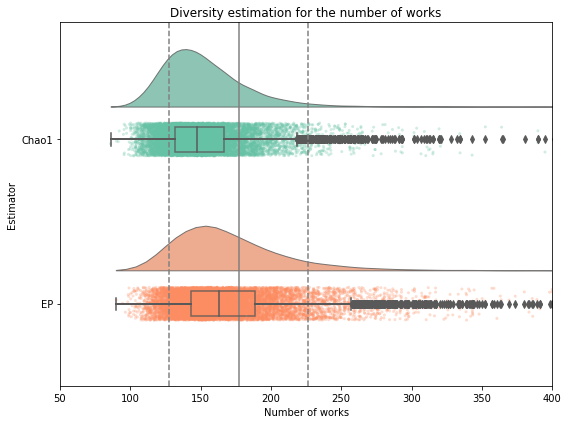

In [17]:
d = list([(x, 'Chao1') for x in chao1_pro])
d += list([(x, 'EP') for x in ep_pro])
bt = pd.DataFrame(d, columns=('bootstrap', 'Estimator'))
bt

fig, ax = plt.subplots(figsize=(8, 6))
pt.RainCloud(
    data=bt, x="Estimator", y="bootstrap", ax=ax, 
    orient="h", alpha=.8, bw=.2, rain_alpha=.3,
);

ax.axvline(jk, c='grey')
ax.axvline(jk_lci, c='grey', ls='--')
ax.axvline(jk_uci, c='grey', ls='--')
ax.set_xlabel('Number of works')

ax.set_xlim([50, 400])
plt.title('Diversity estimation for the number of works')
plt.tight_layout()
plt.savefig('../figures/rainplot.pdf');

### Maculature

An interesting extension of the kind of diversity estimation discussed above is to limit it to the fragmentary remains of witnesses only -- we owe this suggestion to prof. dr. Remco Sleiderink (University of Antwerp). Above, we freely mix physical documents that survived in their entirety (i.e. full codices) with fragmentary remains (sometimes, in the case of deliberately torn up "maculature", only a small shred of a book survives). It is unclear to us at this stage whether that is theoretically acceptable since both document types are characterized by very different survival routes. For that reason, we also include an estimate based on the fragmentary remains only.

Our data indicate whether a witness has survived fragmentarily (as "maculature") or not. In the former case, remnants of the very same source have sometimes emerged in different locales (in that case, multiple signatures are included). These also can be treated as different "sightings", but this time of a manuscript (instead of a work), which allows us to estimate (a lower bound for) the total number of manuscripts that were once cut up to be recycled.

Note that here, we are no longer estimating the loss of "works", but rather the loss of "documents". However, we are not estimating the size of the *full* corpus of documents that once existed (that will happen below), but *only* the size of the specific subgroup of manuscripts that once existed which were processed or recycled into maculature. To the best of our knowledge, very little is known on the ratio of "all manuscripts" vs "the number of manuscripts that were eventually recycled" in any medieval literature, so this is very exciting.

First, we restrict the data to witnesses that survived fragmentarily:

In [18]:
mss_cnts = []
for sign, fragm in zip(df['signature'], df['fragmentary']):
    if fragm: # we ignore witnesses that survived in full
        try:
            mss_cnts.append(len(sign.split(';')))
        except AttributeError:
            pass
mss_cnts = np.array(mss_cnts)

This gives us a (much) smaller subset of the data, as shown in this bar plot:

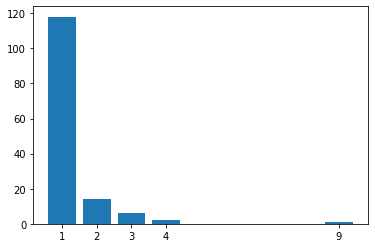

In [19]:
labels, counts = np.unique(mss_cnts, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels);

The following statistics can be reported:

In [20]:
x = mss_cnts
x, n = x[x > 0], x.sum()
t = x.shape[0]
f1, f2 = (x == 1).sum(), (x == 2).sum()
print('number of fragments:', n)
print('number of documents:', t)
print('f1:', f1)
print('f2:', f2)

number of fragments: 181
number of documents: 141
f1: 118
f2: 14


Applying `Chao1` to this restricted data yields the following results:

In [21]:
mac_lci_pro, mac_uci_pro, mac_chao1_pro, mac_pro = chao_estimate(mss_cnts)
print(f'Chao1 (maculature): {mac_pro:.2f} CI({mac_lci_pro:.2f} - {mac_uci_pro:.2f})')

Chao1 (maculature): 635.54 CI(449.85 - 947.25)


To the best of our knowledge, this is the first published estimate of the number of manuscripts in this literature that were recycled into maculature. *If* these numbers are trustworthy -- and that's a big *if* -- they are surprisingly high: in combination with the analyses described below, it would seem that a surprisingly large share (up to one third!) of the manuscripts in this genre were eventually recycled. (And in a way, that's good news, because the discovery rates for fragmentary remains are nowadays much higher than for entire manuscripts.)

## The loss of documents

Above (and in our previous work), we limited ourselves to estimating the number of lost "works" in this data, but the number of lost "documents" is in fact equally relevant for medievalists -- especially for book historians. With the maculature paragraph above, we first ventured into that domain, but now we discuss a more principled approach to this problem.

It should be noted that book historians have published earlier quantitative estimates as to the number of lost books in this domain. These estimates are generally based on medieval libraries of which the historic composition was known (potentially even at different points throughout history): this enables us to empirically observe the loss rates for these specific collections, provided the surviving witnesses are still traceable and identifiable of course. Important references in this respect are the following monographs:
-  H. Wijsman, *Luxury Bound. Illustrated Manuscript Production and Noble and Princely Book Ownership in the Burgundian Netherlands (1400-1550)*, Brepols, 2010.
- E.  Buringh,  *Medieval  Manuscript  Production  in  the  Latin  West,  Explorations  with  a Global Database*, Brill, 2011.
- U. Neddermeyer, *Von der Handschrift zum gedruckten Buch. Schriftlichkeit und Leseinteresse im Mittelalter und in der frühen Neuzeit. Quantitative und qualitative Aspekte*. Harrassowitz, 1998.

Wijsman is the source also cited by Van Oostrom. Middle Dutch chivalric epics are vernacular texts, typically extant in less luxurious, frequently unillustrated manuscripts. For this type of sources, Wijsman estimates an overall survival rate of ~7% for these artifacts -- this loss is naturally much more elevated than for the actual manuscripts, as texts often survive in more than one witnesss. We will use this number as a "baseline" below.

Such data from historical collection catalogues are great and likely very thrustworthy but they come with two issues:
- These collections often come from specific (e.g. monastic) environments but makes it hard to extrapolate them to other collection milieus.
- Such inventories aren't all that frequent: they fact that some of these survived at all, already tells us something about the (unusual protectiveness of?) the environment in which they survived.

The representativeness of these sources is thus not without problems, and we would have have an alternative method to verify or corroborate those findings, that would be great.

### Minimum sampling

We now turn to an extension of `Chao1` which was formulated in the following paper:
    
> A. Chao, R. K. Colwell, C.-W. Lin, N. J. Gotelli, 'Sufficient sampling for asymptotic minimum species richness estimators', *Ecology* 90 (2009) 1125–1133.

The estimator introduced here was meant to inform field workers as to the state of their registration efforts. More specifically it extended `Chao1` to attempt and answer the following questions: how many addition samples or "sightings" of animals would be required to observe each of the currently still unobserved species *at least once*? (This is a very crude summary: please refer to the paper for the full story.) 

In our analogy, this translates to: "How many additional witnesses would we have to find to be able to observe every text that once existed in at least one attestation?" Let us assume (and this seems reasonable) that most of the currently unobserved "works" in our corpus already originally existed in a very low low abundance (i.e. a small number of manuscripts or just a single one per text). This would mean that this estimator can give us a sense of the number of witnesses that originally existed in the corpus and, thus, the loss of documents, rather than works.

> *Note*: not only this method again estimates a lower bound, also for other reasons it can be considered a very conservative guess, because it doesn't account for the phenomenon where a presently unknown text might have existed in multiple copies, that are all lost or unknown presently. This is an important caveat, although we expect its effect to be limited in practice.

The base implementation runs as follows:

In [22]:
def minsample(x):
    n = x.sum()
    x = x[x > 0]
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    
    h = lambda x: 2 * f1 * (1 + x)
    v = lambda x: np.exp(x * (2 * f2 / f1))
    
    # Note that we resort to a crude grid search
    # because scipy's optimization routine
    # regularly got stuck. (See appendix)
    search_space = np.linspace(0, 100, 1e5)
    hs = np.array(h(search_space))
    vs = np.array(v(search_space))
    diffs = np.abs(hs - vs)
    x_ast = search_space[diffs.argmin()]
    return n + n * x_ast

What is the survival rate of documents in this corpus, according to this method?

In [26]:
ms = minsample(cnts)
print('Estimate:', 100 / (minsample(cnts) / cnts.sum()), '% of documents survived')

Estimate: 7.540271105618388 % of documents survived


Also here, a bootstrap can give us a better sense of the uncertainty, which is again not to be ignored: 

In [27]:
def minsample_estimate(x, n_iter=10000, conf=0.95):
    pro = minsample(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=minsample, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [28]:
lci, uci, bt_msample, ms = minsample_estimate(cnts)
print(f'Minimum sampling: {ms:.2f} CI({lci:.2f} - {uci:.2f})')

Minimum sampling: 2214.77 CI(1234.13 - 4108.23)


As you can see, the CI is very wide... Nevertheless, it is surprising that the core estimate (8.2%) is *surprisingly* close to Wijsman's estimate (~7%), although both methods use entirely different data. This needs much more work of course, but this result is very promising. 

## Species Accumulation curve, with miminum sampling effort included

In this, we produce a new kind of plot, where we combine the species accumulation curve (from above, for *works*), with a visualization of the distribution of the bootstrap values from the minimal sampling approach (for *documents*).

In [29]:
def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [30]:
num_docs = len(cnts) + int(minsample(cnts)) # n + m
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(cnts, fn=partial(rarefaction_extrapolation, max_steps=num_docs),
                                            n_iter=100)

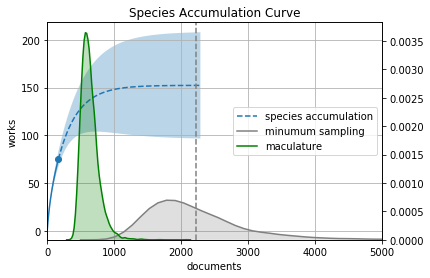

In [31]:
steps = np.arange(1, num_docs)
interpolated = np.arange(1, num_docs) < cnts.sum()
figure = plt.Figure(figsize=(8, 6))
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(cnts.sum(), Dq[cnts.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.axvline(ms, ls='--', c='grey')
plt.xlabel('documents')
plt.ylabel('works')
plt.title('Species Accumulation Curve')
ax2 = plt.gca().twinx()
ax2.plot(np.nan, '--', color='C0', label='species accumulation')
sb.kdeplot(bt_msample, ax=ax2, color='grey', shade=True, label='minumum sampling')
sb.kdeplot(mac_chao1_pro, ax=ax2, color='green', shade=True, label='maculature')
ax2.legend(loc='center right')
plt.xlim([0, 5000])
plt.savefig('../figures/accumulation.pdf');

## Simulations

How well do these estimators perform? Like in many neighboring fields (such as archeology), we have no way to directly evaluate the numbers above (apart from comparing them, of course, to previous work in the field, like Wijsman's or Buringh's). Commonly, scholars therefore turn to simulations, in which we mimic assemblages with the same properties as our medieval data and then artificially impair then, by throwing away documents in a random or stochastic manner. Next, we can apply the diversity estimators from above and see how well they can estimate the original size and diversity of the artifically impaired population. This evaluation strategy isn't perfect, but it's in many ways the best we have. In this section, we described how we went about this.

A first and crucial step is to determine the shape of the distribution of the artificial population that we will generate. Preferably, this would be the kind of long-tail distribution that is typical of cultural data in general -- and also of our texts. Informally, only a few items should be very abundant, whereas the bulk of species should have a very low abundance (as singletons or doubletons).

In a seminal paper on Malaysian butterflies, R.A. Fischer proposed the logseries model to capture the relative abundance of species in an assemblage. The logseries predicts the number of species at different levels of abundance ($n$ individuals) with the formula:

\begin{equation*}
S_n = \alpha x^n / n
\end{equation*}

In code:

In [ ]:
def fisher_richness(idx, alpha, x_):
    return (alpha * (x_ ** idx)) / idx

Here, $S_n$ is the number of species with an abundance of $n$; $x$ = a positive constant ($0 < x < 1$) which is derived from the sample data set but generally approaches 1; $\alpha$ finally is the number of singleton species in the assemblage. We can fit this model to the Middle Dutch data (that seems to follow a surprisingly similar distribution):

In [ ]:
counts = df.groupby('work').size().sort_values(ascending=False).values
n_s = np.array(list(range(1, 20)))
abundance = np.array([np.sum(counts == i) / np.sum(counts) for i in n_s])

popt, pcov = optim.curve_fit(fisher_richness, xdata=n_s, ydata=abundance,
                             bounds=([0, 0.7], [100, 1.05]))
plt.plot(n_s, fisher_richness(n_s, *popt), 'g--',
         label='fit: alpha=%5.3f, x=%5.3f' % tuple(popt))
plt.plot(n_s, abundance, 'o', label='data', alpha=0.5);
plt.legend();

Fisher's logseries can be used to define a discrete probability distribution, parametrized by two values:

- the number of singleton species in the population
- the maximum number of attestations for a single species (to put a practical cap on the distribution)

If we sample $num\_species$ species from this probability distribution, we can simulate virtual assemblages that mimic the properties of the observed data.

In [ ]:
def fisher_pop(n, alpha=0.9, x=5, num_species=600):
    """
    alpha = number of singleton species (f1)
    n = max attestation frequency of a particular species
    x = constant [0, 1], approx. 1
    """
    orders = np.array([fisher_richness(i, alpha, x) for i in range(1, n + 1)])
    props = orders / orders.sum()
    assemblage = []
    elements = [i + 1 for i in np.arange(n)]
    for idx, sample in enumerate(np.random.choice(elements, num_species + 1, p=props)):
        assemblage.extend(sample * [idx])
    return np.array(assemblage)

assemblage = fisher_pop(n=50, alpha=75, x=.99, num_species=250)
assemblage

Let us plot this distribution:

In [ ]:
plt.figure(figsize=(15, 3))
abundance_cnt = np.bincount(assemblage)[1:]
labels, counts = np.unique(abundance_cnt, return_counts=True)
plt.bar(labels, counts, align='center', alpha=0.7)
plt.gca().set_xticks(labels);

We can check whether we got what we wanted via some general statistics:

In [ ]:
print('# works:',  len(abundance_cnt))
print('# documents:', abundance_cnt.sum())
print('# singletons:', abundance_cnt[abundance_cnt == 1].sum(),
      f'({abundance_cnt[abundance_cnt == 1].sum()/len(abundance_cnt) * 100 :.2f}%)')

Next, we can stochastically sample (at certain "keep rates") from this population to simulate the historic loss of documents:

In [ ]:
def loss(assemblage_, keep_rate):
    assemblage_ = list(assemblage_)
    np.random.shuffle(assemblage_)
    retrieved = assemblage_[:int(len(assemblage_) * keep_rate)]
    return np.array(retrieved)

retrieved = loss(assemblage, keep_rate=0.20)
print(retrieved)

Let us check what this sampling did to our statistics:

In [ ]:
_, impaired_counts = np.unique(retrieved, return_counts=True)
print('Impaired population:')
print('# works:',  len(impaired_counts))
print('# documents:', impaired_counts.sum())
print('# singletons:', impaired_counts[impaired_counts == 1].sum(),
      f'({impaired_counts[impaired_counts == 1].sum()/len(impaired_counts) * 100:.2f}%)')

This makes sense (as is also illustrated in the plot below): the number of documents goes down by a factor of roughly the keep rate. Inevitably, we also lose some works, but not at the same rate, since we primarily lose those works that existed in low abundance in the original population. Perhaps counterintuitively, this also implies that the number of singletons proportionally goes up in the impaired sample.

In [ ]:
plt.figure(figsize=(15, 3))
abundance_cnt = np.bincount(assemblage)[1:]
labels, counts = np.unique(abundance_cnt, return_counts=True)
plt.bar(labels, counts, align='center', alpha=0.5, label='original')

impaired_labels_, impaired_counts_ = np.unique(impaired_counts, return_counts=True)
plt.bar(impaired_labels_, impaired_counts_, align='center', alpha=0.5, label='retrieved')
plt.legend();

We can now apply our estimators to the impaired data and have them estimate the diversity of the original population:

In [ ]:
print('Chao1:', chao_richness(impaired_counts))
print('Jackknife:', jackknife(impaired_counts)[0])
print('Egghe & Proot:', ep(impaired_counts))

As usual, `Chao1` is more cautious in this estimation.

### Loss of works

To look at the reconstruction capacity of the estimators, we now set up a more principled series of experiments. In this, we generate a large number of Fisher-distributed populations that we downsample in a stochastic manner. We then each apply each method to estimate the original diversity and compare that estimate to the observable diversity to measure the difference.

Throughout our experiments, we vary a number of important parameters (the number of documents, the keep rate) at linear intervals; others are kept stable (the number of works, $f1$ and $x$):

In [ ]:
num_documents = np.arange(500, 2500, 100)
keep_rates = np.linspace(0.05, 0.95, len(num_documents))
n_experiments = 50

num_works = 250
f1 = 75
x = .99

Note that this process is repeated for each unique setting for 50 times. We now run the simulations and record the results in a `DataFrame`:

In [ ]:
results, doc_results = [], []
for i, num_doc in enumerate(tqdm(num_documents)):
    for kr in keep_rates: 
        for j in range(n_experiments):
            assemblage = fisher_pop(n=num_doc, alpha=f1, x=x, num_species=num_works)
            retrieved = loss(assemblage, keep_rate=kr)
            _, impaired_counts = np.unique(retrieved, return_counts=True)
            results.append({'keep rate': kr, 'estimator': 'Egghe & Proot',
                            'diversity': ep(impaired_counts, alpha=50),
                            'num_documents': num_doc})
            results.append({'keep rate': kr, 'estimator': 'Jackknife',
                            'diversity': jackknife(impaired_counts)[0],
                            'num_documents': num_doc})
            results.append({'keep rate': kr, 'estimator': 'Chao1',
                            'diversity': chao_richness(impaired_counts),
                            'num_documents': i})

S_df = pd.DataFrame(results)

We are now ready to calculate the results. Note that we use a straightforward absolute error measure below (instead of the conventional root mean-squared error) to keep track of the direction of the error: we would like to know whether a metric is under-shooting of over-shooting.

In [ ]:
S_df['Error'] = S_df['diversity'] - num_works # the diversity is a constant!
S_df['AbsError'] = np.abs(S_df['Error'])
S_df.head(10)

First, let's do a violin plot for our three estimators, where the grey line indicates the correct value of 250:

In [ ]:
ax = sb.violinplot(x="estimator", y="diversity", data=S_df)
ax.axhline(num_works, ls='--', c='grey')
plt.title('Reconstructed richness (original = 250)')
plt.tight_layout()
plt.ylabel('Estimated diversity')
plt.savefig('../figures/violin.pdf');

Finally, let's plot the result of the keep rate, fitting a linear trendline to the scores for each estimator:

In [ ]:
g = sb.lmplot(x="keep rate", y="AbsError", hue="estimator", order=1,
              ci=95, data=S_df, scatter_kws={'alpha':0.3}, height=7, aspect=1.6)
plt.title('Absolute reconstruction error (as a function of the per-simulation loss rate)')
plt.subplots_adjust(top=0.9)
plt.ylabel('Absolute error')

Note that the first-order trendline somewhat hides that `Chao1`, while it is the clearly the best metric overall, doesn't perform the best for extremely small keep rates:

In [ ]:
g = sb.lmplot(x="keep rate", y="AbsError", hue="estimator", order=2,
              ci=95, data=S_df, scatter_kws={'alpha':0.3}, height=8, aspect=1.5)
plt.title('Absolute reconstruction error (as a function of the per-simulation loss rate)')
plt.subplots_adjust(top=0.9)
plt.ylabel('Absolute error')
plt.savefig('../figures/lossrates.pdf');

### Technical appendix: Chao1's minimum sampling extension

The extension of `Chao1` for the minimum sampling is in less wide use, so that we provide a little bit more details in this section to verify our implementation's integrity. As can be read in the paper, the goal is to solve an equation to find out where two functions, $h(x)$ and $v(x)$, intersect (for the first and only time):

- $h(x) = 2f_1(1+x)$
- $v(x) = exp[x(2f_2/f_1)]$

Let us plot these functions first for some example data, following the screenshot of the Excel application, provided by Chao et al. in their [supplementary information](https://doi.org/10.6084/m9.figshare.c.3300935.v1) to the original paper. Here goes a partial screenshot of their example:

![Screenshot of the appendix to Chao et al.](https://raw.githubusercontent.com/mikekestemont/minsampling/master/figures/ex_curve.png)

Note that we are interested only in the case of $g=1$, i.e. the situation where we would to observe *all* previously unobserved species. The three base variables can be copied:

In [ ]:
f1 = 3
f2 = 2
n = 161

We can now plot $h(x)$ and $v(x)$ in a suitable range of $x$:

In [ ]:
x = np.linspace(1, 3, 100)
plt.plot(x, 2 * f1 * (1 + x), label='$h(x)$')
plt.plot(x, np.exp(x * (2 * f2 / f1)), label='$v(x)$')
plt.xlabel('x')
plt.tight_layout()
plt.legend();

We need to find out where these two lines intersect (i.e. where the differences is approximately zero). With scipy, we could use an optimization approach as follows:

In [ ]:
from scipy.optimize import fsolve

def intersection(func1, func2, x0):
    return fsolve(lambda x: func1(x) - func2(x), x0)[0]

h = lambda x: 2 * f1 * (1 + x)
v = lambda x: np.exp(x * (2 * f2 / f1))

We can set $x0$ (the starting point for the Newtonian optimization) pragmatically to $n$ to calculate $x^*$:

In [ ]:
x_ast = intersection(h, v, n)
x_ast

Or visually:

In [ ]:
x = np.linspace(1, 3, 100)
plt.plot(x, 2 * f1 * (1 + x), label='$h(x)$')
plt.plot(x, np.exp(x * (2 * f2 / f1)), label='$v(x)$')
plt.axvline(x_ast, linestyle='--', c='grey')
plt.xlabel('x')
plt.legend();

Then, following the paper, we can calculate $m=nx*$:

In [ ]:
m = n * x_ast
m

Above, we resort to a simple grid search however to determine $x^*$, because SciPy's optimization routine often got stuck and it was difficult to initialize it properly. This solution is less elegant of course, but worked better for us in practice. That goes as follows:

In [ ]:
search_space = np.linspace(0, 100, 1e5)
hs = np.array(h(search_space))
vs = np.array(v(search_space))
diffs = np.abs(hs - vs)
x_ast = search_space[diffs.argmin()]
print(n * x_ast)

This code approximates to a reasonable extent the numbers reported in Chao et al.'s appendix.